In [1]:
#intro to classification:

#Binary Classification: target is either one thing or anouther 
# exe: predict if you have heart disease based on health parameters

#Multi-Class Classificaion: target can be one of mutliple options 
#exe: descide if picture of dog or cat

#Multi-Label Classification: target can be mutliple classes at a time
#exe: predict which articles to assign to a wikipedia article


#most machine learning problems are either classification or regession( predict a number or predict a label)

#Pytorch Classification Workflow

#1: collect data turn it into tensors
#2: build or pick a pre-trained model (pick loss function and optimizer, and make a train/test loop)
#3: fit the model to the data and make predictions
#4: evaluate the model
#5: improve through experimentation
#6: save and reload your trained model


# Hyperparameters for a classification neural network( both for binary and multi-class)
'''
input layer shape(in_features) B: same as the number of features(age, sex, height, etc...) M: same

hidden layers B:minimum 1, maximum infinite, M:same

neurons per layer B:usually 10 to 512 M:same

output layer shape (out_features) B:1 C: one per class, so however many classes there are

hidden layer activation  B:usually ReLU, rectified linear unit M:same

output activation B: usually sigmoid(torch.sigmoid) M:softmax (torch.softmax)

loss function B: usually binary crossentropy or torch.nn.BCELoss M:crossentropy loss (torch.nn.CrossEntropyLoss)

optimizer B: stochastic gradient descent (torch.optim.SGD)or Adam     M: same

'''
import torch
from torch import nn

if torch.cuda.is_available():
    device="cuda"
elif torch.backends.mps.is_available():
    device="mps"
else:
    device="cpu"





In [2]:
#first, we make the dataset
#imports from scikit learn
from sklearn.datasets import make_circles

n_samples = 1000

#makes circles by outputing X is an array of tuples with xy coords, and y is the labels those features where 1 is inner circle, 0 is the outer circle
#NOTE: it is not that one is circles and the other isn't, but rather two different types of concentric circles, which the machine must figure out
#to which does each point belong
X,Y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

print(f"First 5 features:\n {X[:5]}")
print(f"Fist 5 labels:\n {Y[:5]}")


First 5 features:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Fist 5 labels:
 [1 1 1 1 0]


In [3]:
#BRIEF COURSE ON PANDA DATAFRAMES: a 2D tabular datastructure
#has rows and columns, where rows are things like observations, and records
#and columns are features, fields or attributes
import pandas as pd

#first you need some data, which is usually a dictionary of type string, any
data = {

    #each of these strings like Name, Age, and City are columns in the dataframe
    #where each of their elements are what goes in that column at different rows
    "Name": ["Alice","Bob","Charlie"],
    "Age": [25, 30, 35],
    "City": ["San Jose", "Freemont", "Menlo"]
}
df = pd.DataFrame(data=data)
print(df)

#accessing a column
df["Name"]
#accessing mutliple columns
df[["Name", "City"]]
#access rows by index
df.iloc[0]
#access rows by index abel
df.loc[0]

#add a new column
df["Salary"] = [100,200,300]

#filter rows:
df[df["Age"] > 30] #returns the rows where "Age" is over 30

#update values:
df.loc[1, "Age"] = 31

#csv io
#pd.read_csv("file.csv")
#df.to_csv("output.csv", index=False)



      Name  Age      City
0    Alice   25  San Jose
1      Bob   30  Freemont
2  Charlie   35     Menlo


In [4]:
#now, to visualize the data:
#first, move those arrays into a pandas dataframe:
import pandas as pd
circles = pd.DataFrame(data={"X1": X[:,0], "X2": X[:,1], "label": Y[:]})
circles.head(10)# make a table with the first 10 elements in the pandas dataframe

#how to find how many values of each class there are:
circles.label.value_counts()
print(circles.loc[0])

X1       0.754246
X2       0.231481
label    1.000000
Name: 0, dtype: float64


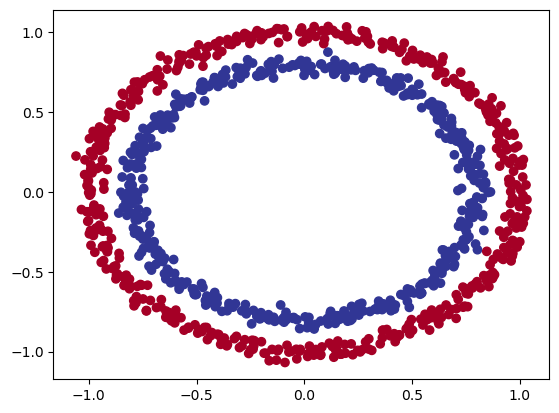

In [5]:
#now plot with mathplotlib
import matplotlib.pyplot as plt
plt.scatter(circles.X1, circles.X2, c=Y,cmap=plt.cm.RdYlBu)
#note: c=y means it sets the colors of each point based on the values of array y
#cmap = plt.cm.RdYlBu sets the color map, which means that lower y values will appear more red, higher more blue

In [6]:
X.shape, Y.shape #ndarrays are numpy arrays, so the .shape returns a tuple respresentation of the shape, like in pytorch tensors

#it helps to visualize the features and labels for a single sample, just so you can get an understanding of how the size works
X_sample = X[0]
Y_sample = Y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {Y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {Y_sample.shape}")
#this shows us that the second dimension of X has 2 features (vector) while the second dimension of Y has 1 features (scalar)

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [7]:
#turn data into tensors and make the train_test split
#first, turn out data which is currently in two numpy arrays into two pytorch tensors using torch.Tensor.from_numpy()
# then, use the same method used previously to make a train/test split for the data
import torch
X_data = torch.from_numpy(X).type(torch.float) #dont use X and then X in the result because jupyter stores variables between executions so it fail
Y_labels = torch.from_numpy(Y).type(torch.float)
X,Y, X.shape, Y.shape


#now lets do the same manuver from before to make the train-test split
'''
train_test_split=(0.8,0.2)
split_index = int(len(X)*train_test_split[0])
X_train, X_test = X_data[:split_index], X_data[split_index:]
Y_train, Y_test = Y_labels[:split_index], Y_labels[split_index:]
'''
# actually, we can use the train_test_split() function from scikit-learn
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_labels,test_size=0.2,random_state=42) #test_size is how much test data to go in each, and random_state is for
len(X_train), len(X_test), len(Y_train), len(Y_test)


(800, 200, 800, 200)

In [8]:
#Next, time to build the model
#NOTE: this setup of features and labels is called supervised learning
#1: device agnostic code
#2: contruct a model as a subclass of nn.Module
#3: define loss and optimizer
#4:create a training loop

torch.manual_seed(42)
from torch import nn
# imput tensor is (1000,2), so in_features is 2
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self,x :torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))

model_0 = CircleModel() #initially on the cpu, must be moved, also remember to move the data
model_0.to(device)
model_0

#WHATS HAPPENING: layer1 is taking the 2 imput features and produces 5 output features (called hidden neurons)
#NOTE: the number of hidden units/neurons in a model is a Hyperparameter, something you set yourself


CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
#alternative definition using nn.Sequential(), this is a class, like nn.Module that runs all of its layers sequentially, 
#passing data from one to anouther in the order they appear

model_seq = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model_seq #this does the same thing as the previous model, only this is more compact. In reality, you can combine the squential models with the other ones
#to make more complex models

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
#make predictions with the model
model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(Y_test)}, Shape: {Y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{Y_test[:10]}")

#NOTE: right now the predictions are not in the form of the labels, but we can adjust that later


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='mps:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
#loss function and optimizers

# stochastic gradient descent 
# adam optimizer
#binary cross entropy
# cross entropy loss
# mean absolute error
# mean squared error


#two types of BCE loss implimentations
# torch.nn.BCELoss()
# torch.nn.BCEWithLogitsLoss()
#difference, BCEWithLogitsLoss() has a sigmoid layer built-in (essentially, it takes the output, which for us is a tensor of size (1000,1) and
# passes it into a sigmoid layer, which will turn the output into a basically 0 or a basically 1, and then compare it to the output
#NOTE: for more advances projects, it may make sense to use a sigmoid layer into a BCELoss, but since we will only need one sigmoid
#this is fine the way it is
# also, it says it is more stable than using BCELoss after a nn.Sigmoid layer

#how BCE WORKS: (y is the ground truth, p is the logit for the prediction post sigmoid (from 0 to 1))
# BCE Loss per prediction BCE(y,p) = -[y*log(p) + (1-y)log(1-p)]
# if y is 1, p=1 should give a loss of 0 and if p=0 is should give a huge loss


loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [12]:
#Evaluation Metric:
# an evaluation metric can provide more feedback on how your model is doing, beyond just the loss function
#one such metric is accuracy
#accuracy = total number of correct predictions / total number of predictions

#predictions are the output of the model, of size (200,1), and so is the ground truth (test data only)
'''
def accuracy_fn(predictions, ground_truth):
    length_of_predictions = len(predictions)
    number_correct_predictions = 0
    for i in range(length_of_predictions):
        if predictions[i][0] == ground_truth[i][0]:
            number_correct_predictions=number_correct_predictions+1
    return number_correct_predictions/length_of_predictions
'''

#this one is better, since it works for tensors of all dimensions, not just 2d tensors
def accuracy_fn(Y_true,Y_pred):
    #for accuracy, can use the torch.eq() which calculates where two tensors are equal, and returns a tensor where true means they are and 
    #false means they are not
    correct = torch.eq(Y_true, Y_pred).sum().item() #sums the places where the tensors are true, and then item turns the tensor into an integer
    acc = (correct / len(Y_pred)) * 100
    return acc

#this will be measured when the model is training along with its loss to gauge its preformance











In [13]:
#training loop
'''
First, lets understand how this works:
if you pass in 5 random valeus ot the model like Y_preds = model_0(X_test.to(device)[:5])
it will output some random values like tensor([[0.0555],[0.0169],[0.2254],[0.0071],[0.3345]]
which is just the result of two random layers of linear operations, where Y = matmul(X,W^T)+bias
Where the raw output of this equation and in turn our model are called LOGITS

However, these numbers are hard to interpret because they are not similar to our truth labels, so we can apply a sigmoid function

Y_pred_probs = torch.sigmoid(Y_preds) #notice how this is different from nn.Sigmoid() which is a class for a neural network layer
now, the pred_probs look like this [0.5139],[0.5042],[0.5561],[0.5018],[0.5829]], which are called prediction probabilities, or how much 
the model things the output is one class or anouther

In our case, we are dealing with Binary Classification, (0 or 1) , and the result of the sigmoid is also between a 0 and a 1, so we can create 
descision boundaries that match these label definitions, where :
<0.5 is 0, or class 0, and >0.5 is 1 or class 1

Now, in full: the output of our model will be of size (batch_size,1) and will be floats from -1 to 1, but we want outputs to look like 1 and 0, so do this


y_preds = model_0(X_train.to(device))[:5]
y_pred_labels = torch.round(torch.sigmoid(Y_preds)) #now, in shape (1000,1), but we want it to be flateded
y_pred_labels = y_pred_labels.squeeze() #(now in size (1000,), just like the labels)

#NOTE: sigmoid function is only for binary classification, use softmax for mutli-class
#NOTE: this is not necessary when using nn.BCEWithLogitsLoss since it works directly on the logits and has the above stull already inside 








'''



#set manual seed
torch.manual_seed(42)


#variables
epochs = 100
training_loss_values = []
testing_loss_values = []
testing_accuracy_values = []
number_of_epochs = []

#Now, move the data to the GPU(THE BELOW CODE IS WRONG AND CREATES A NEW VARIABEL TENSOR AND ASSIGNS IT )
"""tensors = (X_train, X_test,Y_train,Y_test)
for tensor in tensors:
    tensor = tensor.to(device)"""
#To bulk move to GPU:
X_train, X_test, Y_train, Y_test = [tensor.to(device) for tensor in (X_train, X_test, Y_train, Y_test)]


#now start the loop:

for epoch in range(epochs):

    #first, move model to learning mode:
    model_0.train()
    #then, do a first foward pass on the data, outputing raw logits:
    Y_pred_logits = model_0(X_train).squeeze() #important so that data is consistent
    #can also get them as labels:
    Y_preds = torch.round(torch.sigmoid(Y_pred_logits)) #now in the form (1000,) with 0 and 1


    #now calculate the loss of the function from the predicted values and the output (using nn.BCEWithLogitsLoss)
    loss = loss_fn(Y_pred_logits,Y_train)

    acc = accuracy_fn(Y_pred=Y_preds,Y_true=Y_train)


    #now, zero the gradients to prepare for backprop
    optimizer.zero_grad()
    #now, do a backwards pass on the data and calculate the gradient relative to each parameter versus the loss function
    loss.backward()
    #Now that the gradients are calculated, step the optimizer to correct the parameters according to what lowers the loss function the best
    optimizer.step()

    #NOW THE TESTING LOOP

    model_0.eval()

    with torch.inference_mode():
        #looks like we are testing every epoch
        #forward pass:
        test_pred_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_pred_logits))

        #calculate the loss
        test_loss = loss_fn(test_pred_logits,Y_test)

        #calculate accuracy
        test_acc = accuracy_fn(Y_pred=test_pred,Y_true=Y_test)

        #display results
        training_loss_values.append(loss.detach().cpu().numpy())
        testing_loss_values.append(test_loss.detach().cpu().numpy())
        testing_accuracy_values.append(test_acc)
        number_of_epochs.append(epoch)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | BCE Train Loss :{loss:.5f} | BCE Test Loss :{test_loss:.5f} | Train Accuracy :{acc} | Test Accuracy: {test_acc}")
            #where :.5f, means round to 5 decimal places and express as a fixed point (floating point) number















Epoch: 0 | BCE Train Loss :0.69569 | BCE Test Loss :0.69721 | Train Accuracy :50.0 | Test Accuracy: 50.0
Epoch: 10 | BCE Train Loss :0.69403 | BCE Test Loss :0.69615 | Train Accuracy :50.0 | Test Accuracy: 50.0
Epoch: 20 | BCE Train Loss :0.69343 | BCE Test Loss :0.69585 | Train Accuracy :46.0 | Test Accuracy: 48.5
Epoch: 30 | BCE Train Loss :0.69321 | BCE Test Loss :0.69577 | Train Accuracy :49.0 | Test Accuracy: 47.5
Epoch: 40 | BCE Train Loss :0.69312 | BCE Test Loss :0.69573 | Train Accuracy :49.5 | Test Accuracy: 46.5
Epoch: 50 | BCE Train Loss :0.69308 | BCE Test Loss :0.69569 | Train Accuracy :50.375 | Test Accuracy: 46.5
Epoch: 60 | BCE Train Loss :0.69306 | BCE Test Loss :0.69564 | Train Accuracy :50.5 | Test Accuracy: 46.5
Epoch: 70 | BCE Train Loss :0.69305 | BCE Test Loss :0.69559 | Train Accuracy :50.5 | Test Accuracy: 46.5
Epoch: 80 | BCE Train Loss :0.69304 | BCE Test Loss :0.69553 | Train Accuracy :50.74999999999999 | Test Accuracy: 46.5
Epoch: 90 | BCE Train Loss :0.69

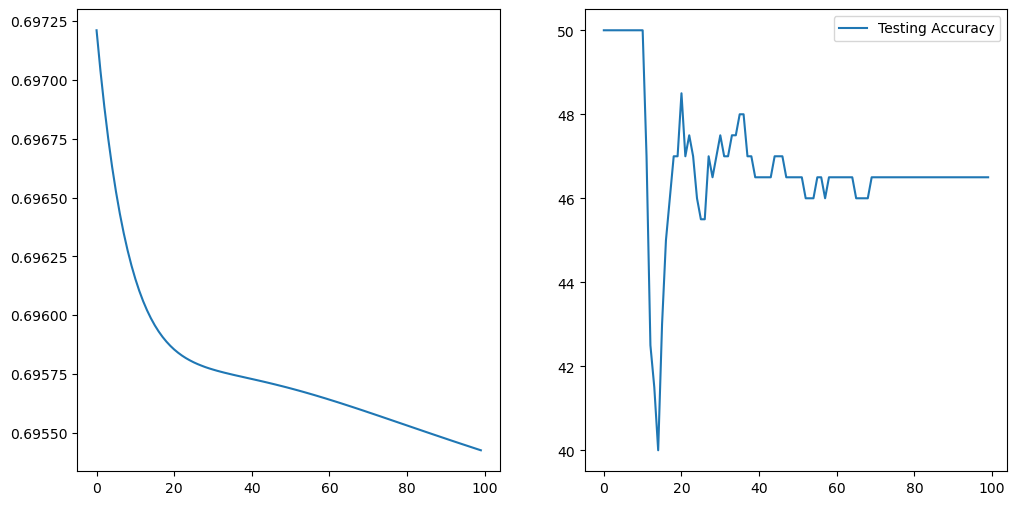

In [14]:
#plot loss and accuracy
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(number_of_epochs,testing_loss_values,label="Testing Loss")
plt.subplot(1,2,2)
plt.plot(number_of_epochs,testing_accuracy_values, label="Testing Accuracy")
plt.legend()


In [15]:
#why is our model preforming so poorly?, wit allmost none of the values working at all
import requests
from pathlib import Path
import torchvision

if Path("helper_functions.py").is_file():
    print("helper_functions.py allready downloaded, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary







helper_functions.py allready downloaded, skipping download


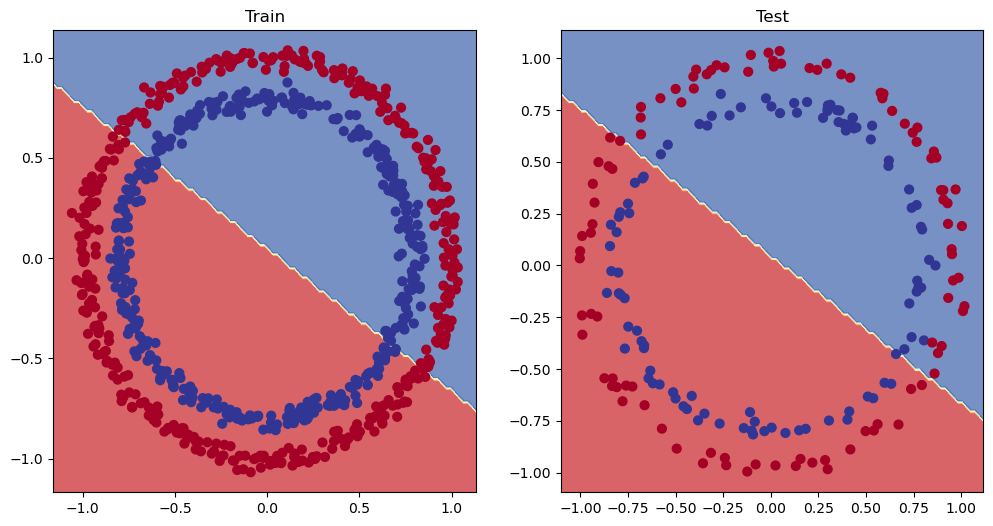

In [16]:
#Now, lets plot the results of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) #where 1 is number of rows in the grid, 2 is the number of columsn in the grid, and 1 is the index of the current plot)left to right)
#indexes at 1 tho...
plt.title("Train")
plot_decision_boundary(model_0,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,Y_test)




In [17]:
#It looks like the model is trying to split the red and blue dots in two using a red line, which considering our model is a circle, it wont affect much
# THus, our model is underfitting the data, because it is not learning predictive patterns in the data

#How to improve the model:
#1: add more layers (making the network deeper)
#2: add mode hidden units per layer (making network wider)
#3: fitting for longer (more epochs)
#4: changing activation functions (not all data can be fitted with straight lines, so non-linear activation functions can help with that)
#5: change the learning rate
#6: change the loss function
#7: transfer learning (use pre-trained models)

In [18]:
#for our first experiment, lets add an extra layer to the model, fit for longer (1000 epochs), and increase the number of hidden units to 10 from 5
#lets try the second model architecture, with anouther layer and more hidden units

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = CircleModelV2()
model_1.to(device)
model_1

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [19]:
#loss function and optimizer for the new model:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [20]:
#now, remake the training loop but with 1000 epochs rather that 100

#define your variables
epochs = 1000
training_loss_values = []
testing_loss_values = []
training_accuracy_values = []
testing_accuracy_values = []
number_of_epochs = []

#now, move your tensors to the gpu
X_train,X_test,Y_train,Y_test = (tensor.to(device) for tensor in (X_train,X_test,Y_train,Y_test))

#now for the new training loop for the model

for epoch in range(epochs):

    #put model in training mode:
    model_1.train()
    #now, do a forward pass on the data, remembering that X_train is of type (800,2)
    Y_pred_logits = model_1(X_train).squeeze() #must squeeze since return type is (800,1) and Y_train is of shape (800,)
    #now for the accuracy comparison, need the data rounded and sigmoided
    Y_preds = torch.round(torch.sigmoid(Y_pred_logits))
    #now we calculate the loss of our model
    loss = loss_fn(Y_pred_logits,Y_train)
    #Now, we will calculate the accuracy of the data
    acc = accuracy_fn(Y_pred=Y_preds,Y_true=Y_train)
    #now that we have the loss function, we zero the gradients to prepare for backprop
    optimizer.zero_grad()
    #now, we will backpropogate the gradients to find the grads for each parameter relative to the loss function
    loss.backward()
    #now that the grandietns are found, we will step the parameters in the direction of gradient descent times the learning rate
    optimizer.step()

    #now we will start the testing loop, which we will do every epoch
    
    model_1.eval()
    with torch.inference_mode():
        #first we will to a forward pass on the data to see how it looks
        test_logits_preds = model_1(X_test).squeeze() #must squeeze since the data is of type (200,1) abd 
        test_preds = torch.round(torch.sigmoid(test_pred_logits))
        #now, we will calculate the loss and accuracy of the testing data
        test_loss = loss_fn(test_logits_preds,Y_test)
        test_acc = accuracy_fn(Y_pred=test_preds,Y_true=Y_test)
        #Now, we add the data to the system and print every 10 epochs
        training_loss_values.append(loss.detach().cpu().numpy())
        testing_loss_values.append(loss.detach().cpu().numpy())
        training_accuracy_values.append(acc)
        testing_accuracy_values.append(test_acc)
        number_of_epochs.append(epoch)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | BCE Training Loss {loss:.5f} | BCE Testing Loss {test_loss:.5f} | Training Accuracy: {acc:.2f} | Testing Accuracy: {test_acc:.2f}")






Epoch: 0 | BCE Training Loss 0.69396 | BCE Testing Loss 0.69261 | Training Accuracy: 50.88 | Testing Accuracy: 46.50
Epoch: 10 | BCE Training Loss 0.69369 | BCE Testing Loss 0.69270 | Training Accuracy: 50.25 | Testing Accuracy: 46.50
Epoch: 20 | BCE Training Loss 0.69351 | BCE Testing Loss 0.69283 | Training Accuracy: 50.12 | Testing Accuracy: 46.50
Epoch: 30 | BCE Training Loss 0.69339 | BCE Testing Loss 0.69297 | Training Accuracy: 50.50 | Testing Accuracy: 46.50
Epoch: 40 | BCE Training Loss 0.69329 | BCE Testing Loss 0.69310 | Training Accuracy: 50.38 | Testing Accuracy: 46.50
Epoch: 50 | BCE Training Loss 0.69322 | BCE Testing Loss 0.69324 | Training Accuracy: 49.88 | Testing Accuracy: 46.50
Epoch: 60 | BCE Training Loss 0.69317 | BCE Testing Loss 0.69336 | Training Accuracy: 49.38 | Testing Accuracy: 46.50
Epoch: 70 | BCE Training Loss 0.69312 | BCE Testing Loss 0.69348 | Training Accuracy: 49.38 | Testing Accuracy: 46.50
Epoch: 80 | BCE Training Loss 0.69309 | BCE Testing Loss 

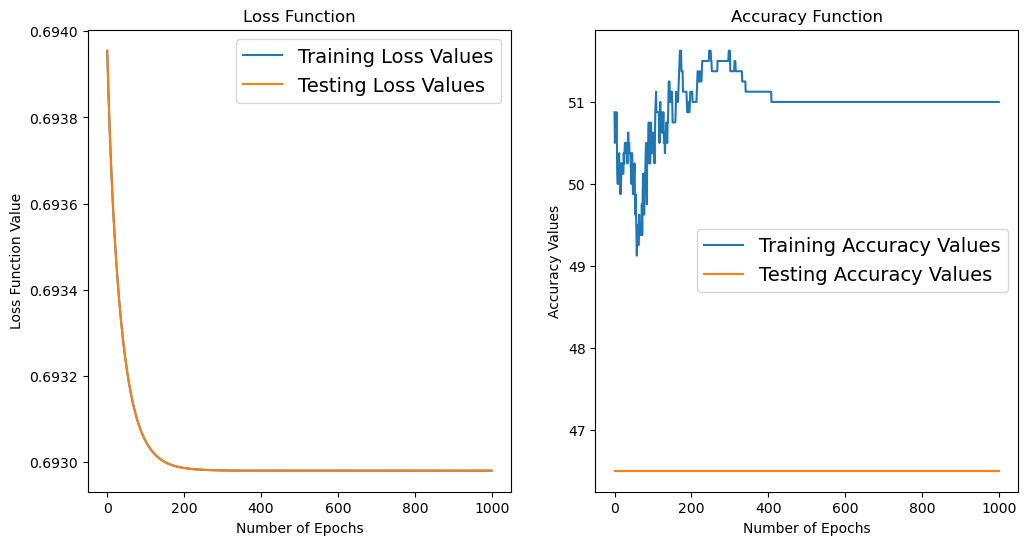

In [21]:
#first, visualize the training and testing loss functions
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Loss Function")
plt.plot(number_of_epochs,training_loss_values,label="Training Loss Values")
plt.plot(number_of_epochs,testing_loss_values,label="Testing Loss Values")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Value")
plt.legend(prop={"size":14})

plt.subplot(1,2,2)
plt.title("Accuracy Function")
plt.plot(number_of_epochs,training_accuracy_values,label="Training Accuracy Values")
plt.plot(number_of_epochs, testing_accuracy_values, label="Testing Accuracy Values")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy Values")
plt.legend(prop={"size":14})




In [22]:
#now, lets get a better visual on the accuracy graphs: first, redo the importing using Path and requests, then plot it using plot_descision_boundary
import requests
from pathlib import Path 


if Path("helper_functions.py").is_file(): #makes a Path object pointing to the file named helper_function.py and checks if the file exists and is not a directory
    print("You already have the file helper_functions.py")
else: 
    print("Downloading helper_functions.py")
    request = requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    #this sends an HTTP get request using the requests library to download the file from github, and stores the result in the request object
    #NOTE: while this code downloads the content, it doesn't save to disk, only storing it temporarily in memory
    with open(file="helper_functions.py",mode="wb") as f:
        f.write(request.content)
        #the with open is a context manager, meaning it automatically takes care of opening and closing the file once it leaves the context
        #(no need to call f.close)
        #opens the file with the filename(if it doesn't exist it just makes one), and the mode is "wb" or write binary(used for non-text files)
        #Essentially created a file pointer object and assigns it to f, which is a BufferedWriter object
        #then, f.write() writes data to the file, which is the raw bytes returned by request.context (use request.text for text files)


You already have the file helper_functions.py


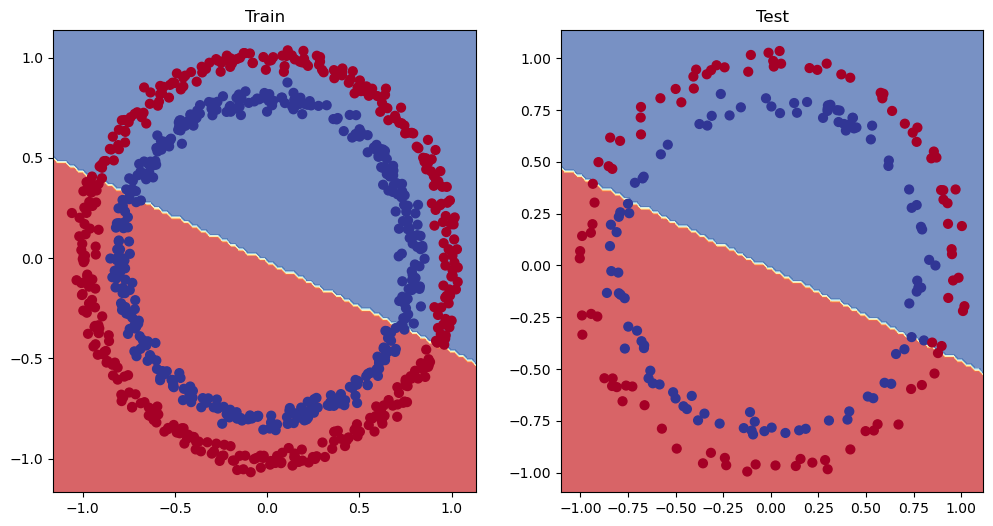

In [23]:
#now, lets display the results:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_1,X=X_train,y=Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_1,X=X_test,y=Y_test)

In [24]:
#lets now try the origional linear data on our model to see if it works better:
weight = 0.7
bias = 0.3
start = 1
end = 10
step = 0.1

X_regression = torch.arange(start=start,end=end,step=step,dtype=torch.float)
Y_regression = weight * X_regression + bias
X_regression[:5],Y_regression[:5]


(tensor([1.0000, 1.1000, 1.2000, 1.3000, 1.4000]),
 tensor([1.0000, 1.0700, 1.1400, 1.2100, 1.2800]))

In [25]:
#do the datasplit:
from sklearn.model_selection import train_test_split

X_regression_training,X_regression_testing,Y_regression_training,Y_regression_testing = train_test_split(X_regression,Y_regression,test_size=0.2,random_state=42)
X_regression_training,X_regression_testing,Y_regression_training,Y_regression_testing = (tensor.reshape(len(tensor),1) for tensor in (X_regression_training,X_regression_testing,Y_regression_training,Y_regression_testing))
for tensor in X_regression_training,X_regression_testing,Y_regression_training,Y_regression_testing: print(tensor.shape)

torch.Size([72, 1])
torch.Size([18, 1])
torch.Size([72, 1])
torch.Size([18, 1])


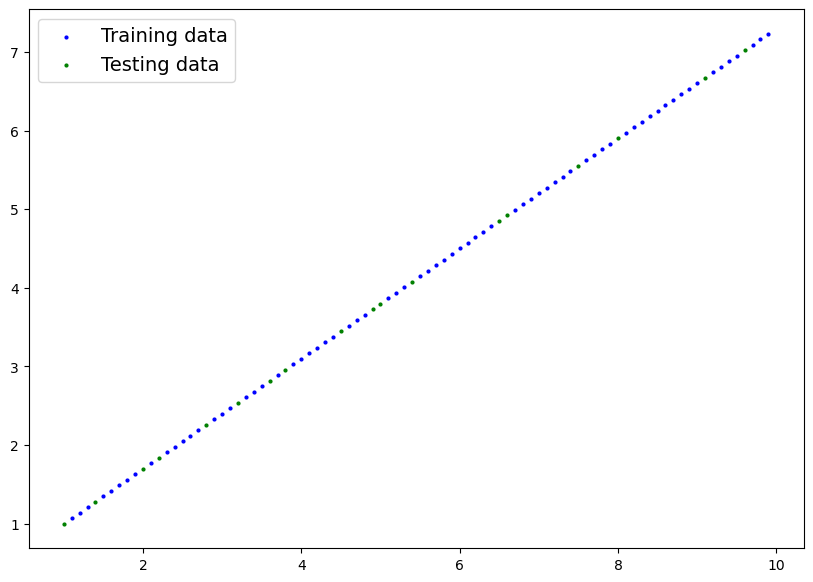

In [26]:
#Now, we make our model: modified
from helper_functions import plot_predictions
plot_predictions(train_data=X_regression_training,train_labels=Y_regression_training,test_data=X_regression_testing,test_labels=Y_regression_testing)


In [27]:
#Now, the model
from torch import nn
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
#now the loss function:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.001)
print(f"X training shape: {X_regression_training.shape}")

X training shape: torch.Size([72, 1])


In [29]:
#now the training loop:

#variables
epochs = 1000
training_loss_values = []
testing_loss_values = []
number_of_epochs = []

#now move the data to the GPU
X_regression_training,X_regression_testing,Y_regression_training,Y_regression_testing = (tensor.to(device) for tensor in (X_regression_training,X_regression_testing,Y_regression_training,Y_regression_testing))

for epoch in range(epochs):
    #set it into training mode
    model_2.train()
    #do a forward pass on the data, which also creates teh computational graph
    Y_regression_preds = model_2(X_regression_training)
    #now, find the loss function of our results
    loss_regression = loss_fn(Y_regression_preds,Y_regression_training)
    #now, we zero the gradients and prepare for backprop
    optimizer.zero_grad()
    #now, we do a backward pass through the data and via backpropagation and chainrule find the gradient of each parameter with respect to the loss
    loss_regression.backward() #MAKE SURE IT IS THE LOSS, WHICH IS THE VERSION OF THE LOSS FUNCTION FOR OUR PROBLEM SPECIFICALLY
    #now that we have the gradients, step the optimizer to change the parameters in accordance to their gradients and the learning rate
    optimizer.step()

    #now the testing loop:
    if epoch % 10 == 0:
        model_2.eval()
        with torch.inference_mode():
            #forward pass
            test_regression_preds = model_2(X_regression_testing)
            #find the loss
            test_regression_loss = loss_fn(test_regression_preds,Y_regression_testing)
            #now save the training and testing values in the array for graphing:
            training_loss_values.append(loss_regression.detach().cpu().numpy())
            testing_loss_values.append(test_regression_loss.detach().cpu().numpy())
            number_of_epochs.append(epoch)
            #print out the progress every 10 epochs:
        
            print(f"Epoch: {epoch} | MAE Training Loss: {loss_regression} | MAE Testing Loss : {test_regression_loss}")




Epoch: 0 | MAE Training Loss: 3.5148284435272217 | MAE Testing Loss : 3.0217201709747314
Epoch: 10 | MAE Training Loss: 2.7661967277526855 | MAE Testing Loss : 2.3640458583831787
Epoch: 20 | MAE Training Loss: 1.9188207387924194 | MAE Testing Loss : 1.6157463788986206
Epoch: 30 | MAE Training Loss: 0.9155296683311462 | MAE Testing Loss : 0.7259787321090698
Epoch: 40 | MAE Training Loss: 0.0664638951420784 | MAE Testing Loss : 0.07831943035125732
Epoch: 50 | MAE Training Loss: 0.06237783655524254 | MAE Testing Loss : 0.0746515765786171
Epoch: 60 | MAE Training Loss: 0.058049559593200684 | MAE Testing Loss : 0.06948164850473404
Epoch: 70 | MAE Training Loss: 0.055576391518116 | MAE Testing Loss : 0.06664476543664932
Epoch: 80 | MAE Training Loss: 0.059390902519226074 | MAE Testing Loss : 0.06726004183292389
Epoch: 90 | MAE Training Loss: 0.07186306267976761 | MAE Testing Loss : 0.06093335896730423
Epoch: 100 | MAE Training Loss: 0.06827567517757416 | MAE Testing Loss : 0.0582848004996776

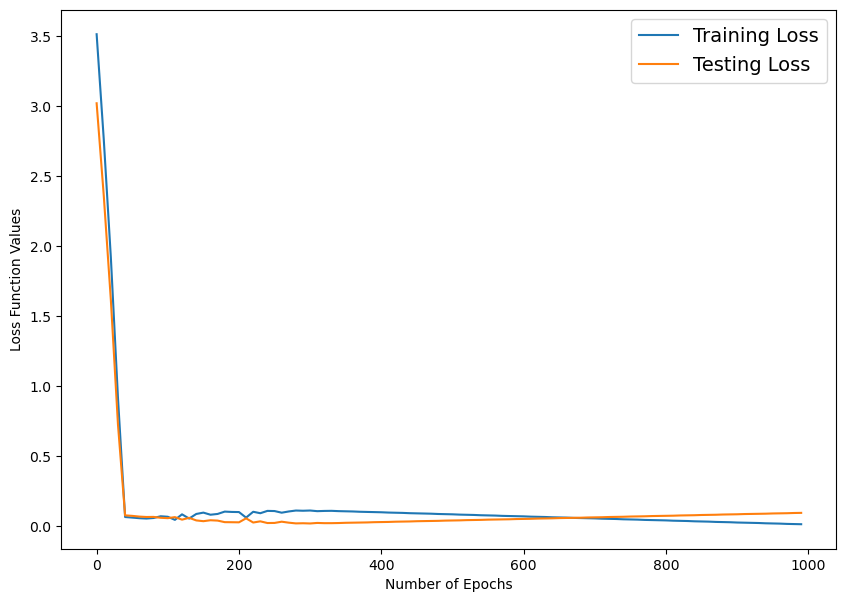

In [30]:
#now, graph the loss function for training and testing:
plt.figure(figsize=(10,7))
plt.plot(number_of_epochs,training_loss_values,label="Training Loss")
plt.plot(number_of_epochs,testing_loss_values, label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Values")
plt.legend(prop={"size":14})

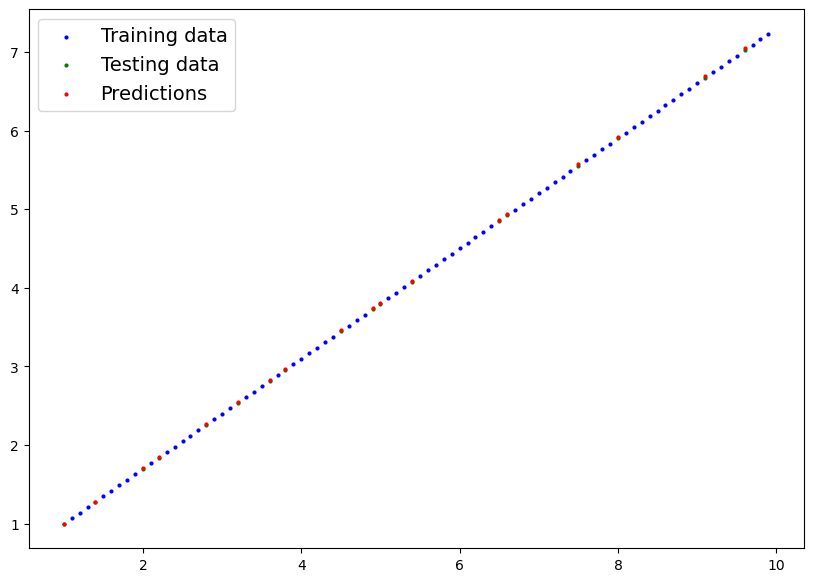

In [31]:
#now, lets plot the final models predictions to see if they are good:
model_2.eval()
with torch.inference_mode():
    final_regression_preds = model_2(X_regression_testing)

plot_predictions(train_data=X_regression_training.detach().cpu(),train_labels=Y_regression_training.detach().cpu(),test_data=X_regression_testing.detach().cpu(),
                 test_labels=Y_regression_testing.detach().cpu(), predictions=final_regression_preds.detach().cpu())


In [32]:
#now, just for practice lets try to save our model
from pathlib import Path 

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "02_Linear_Practice"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#now to actually save the model
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)


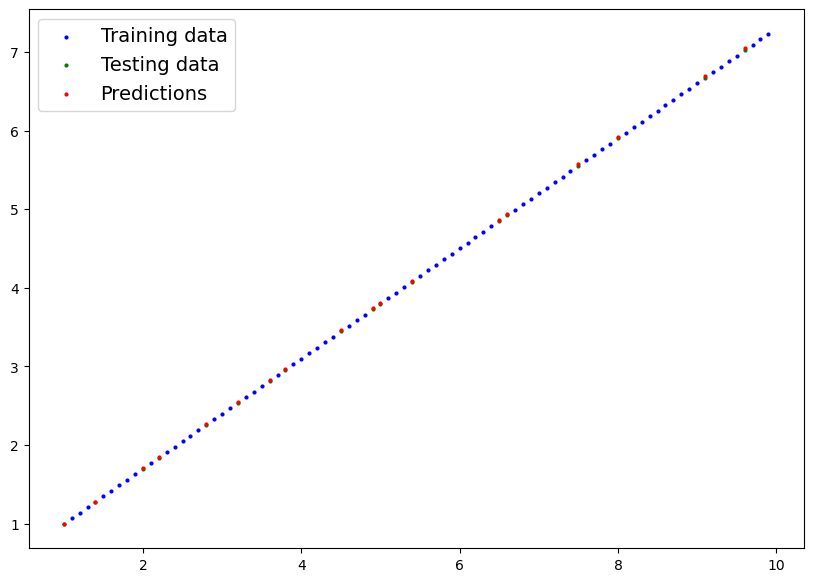

In [33]:
#now lets load the model again and try inference

model_2_loaded = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH,weights_only=True))

model_2_loaded.eval()
with torch.inference_mode():
    loaded_regression_preds = model_2_loaded(X_regression_testing)
plot_predictions(train_data=X_regression_training.detach().cpu(),train_labels=Y_regression_training.detach().cpu(),test_data=X_regression_testing.detach().cpu(),
                 test_labels=Y_regression_testing.detach().cpu(), predictions=loaded_regression_preds.detach().cpu())



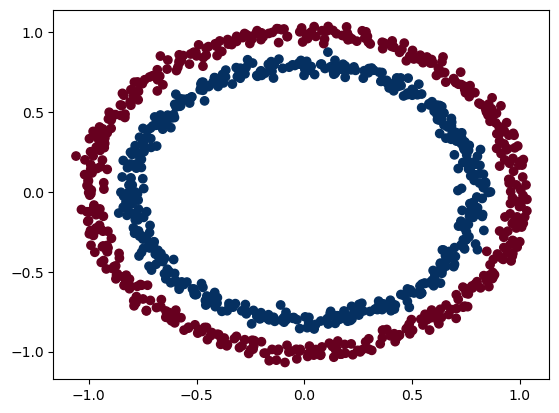

In [34]:
#BUT WHAT ABOUT THE CIRCLES??? WE GOTTA TRY ADDING NON-LINEARITY!!!
#use sklearn, and the make_circles method
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X,Y = make_circles(n_samples=n_samples,noise=0.03,random_state=42)
#now, we plot the points
plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.cm.RdBu)




In [35]:
#now the train-test split
from sklearn.model_selection import train_test_split

#the data must be in tensor form.
X_data = torch.from_numpy(X).type(torch.float).to(device) #remember mps doesn't support anyting but torch.float!(32 bit floats)
Y_labels = torch.from_numpy(Y).type(torch.float).to(device)

X_training,X_testing,Y_training,Y_testing = train_test_split(X_data,Y_labels,test_size=0.2,random_state=42)
X_training,X_testing,Y_training,Y_testing

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         ...,
         [ 0.0157, -1.0300],
         [ 1.0110,  0.1680],
         [ 0.5578, -0.5709]], device='mps:0'),
 tensor([[-3.7519e-01,  6.8266e-01],
         [ 1.5380e-02,  9.6003e-01],
         [-7.0278e-01, -3.1472e-01],
         [-2.8525e-01,  9.6638e-01],
         [ 4.0242e-01, -7.4375e-01],
         [ 6.3228e-01, -5.7111e-01],
         [ 8.5607e-01,  5.4994e-01],
         [ 1.0034e+00,  1.9028e-01],
         [-7.4892e-01, -2.9511e-01],
         [ 5.3780e-02,  9.7388e-01],
         [-4.7020e-01,  7.8749e-01],
         [-2.1686e-01,  7.2418e-01],
         [ 9.7026e-01,  3.6688e-01],
         [-5.8446e-01, -5.7415e-01],
         [-9.1147e-01, -2.4631e-01],
         [ 7.6892e-01, -7.3249e-02],
         [ 3.8408e-01,  6.8299e-01],
         [-6.8364e-01,  7.1417e-01],
         [-5.7777e-01,  5.3652e-01],
         [-8.3274e-01,  4.6625e-01],
         [ 1.2448e-02,  9.8709e-01],
         [ 1.0091

In [36]:
#Now, lets build a model with non-linearity
#think of how much you can draw with unlimited straight and non-straight lines
#one of the best non-linear functions is torch.nn.ReLU() or rectified linear unit
from torch import nn

class NonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()
    def forward(self,x): 
        #try to intersperce the ReLu function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = NonLinearModel().to(device)
model_3

#use this website:https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.08877&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false
#to learn more
#essentially, the ReLU is a piecewise linear function that returns the output if it is positive, and it it is negative, it returns a 0
#the sigmoid and hyperbolic tangent activation functions cannot be used in models with many layers because of the vanishing gradient problem
'''
Here is the problem:
sigmoid formula is 1 / (1 + e^(-x)), so its derivative with respect to x is
sig(x) * (1- sig(x)), which is allways between 0 and 0.25
if the model has many layers, this contant multiplication by between 0 and 0.25 will eventually make the gradient non-existant for the latter layers
thus, use the ReLU function, which again just returns the output if it is positive, and turns it to 0 if negative. This is just a way to add some 
non-linearity to the data without ruining the gradient

if you just use linear layers, the result will still be just one large linear transformation(can test this)
regardless of how many layers, its the same as one large matrix multiplication

'''







'\nHere is the problem:\nsigmoid formula is 1 / (1 + e^(-x)), so its derivative with respect to x is\nsig(x) * (1- sig(x)), which is allways between 0 and 0.25\nif the model has many layers, this contant multiplication by between 0 and 0.25 will eventually make the gradient non-existant for the latter layers\nthus, use the ReLU function, which again just returns the output if it is positive, and turns it to 0 if negative. This is just a way to add some \nnon-linearity to the data without ruining the gradient\n\nif you just use linear layers, the result will still be just one large linear transformation(can test this)\nregardless of how many layers, its the same as one large matrix multiplication\n\n'

In [37]:
#now, lets set up the optimizer and loss
loss_fn = torch.nn.BCEWithLogitsLoss() #use binary cross entropy with logits, since we are not going to add a sigmoid function at the end
optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.1)

In [38]:
#NEW STEP, JUST FOR ME!!! Impliment a csv writer to record the data in your experiment rather that storing it in a memory array
import csv
from pathlib import Path

RESULTS_PATH = Path("Model_Results")
RESULTS_PATH.mkdir(parents=True,exist_ok=True)

RESULTS_FILE = "model_3_exp1.csv"
RESULTS_FILE_PATH = RESULTS_PATH / RESULTS_FILE



In [39]:
#Now for the training and testing loop

#first, lets define the parameters:
torch.manual_seed(42)
epochs = 1000

#Move the data to the GPU:
X_training,X_testing,Y_training,Y_testing = (tensor.to(device) for tensor in (X_training,X_testing,Y_training,Y_testing))



with open(file=RESULTS_FILE_PATH,mode="w",newline="") as file:

    writer = csv.writer(file)
    writer.writerow(["epoch", "train_loss", "test_loss", "train_acc", "test_acc"])

    for epoch in range(epochs):
        #forward pass on the data, yielding the logits and predictions
        model_3.train()
        Y_pred_logits = model_3(X_training).squeeze() #since output is of type (batch_size,1)
        Y_preds = torch.round(torch.sigmoid(Y_pred_logits))

        #now find the loss / accuracy
        loss = loss_fn(Y_pred_logits,Y_training)
        acc = accuracy_fn(Y_pred=Y_preds,Y_true=Y_training)

        #now, zero the gradients in preparation for backprop
        optimizer.zero_grad()

        #now, preform backpropagation
        loss.backward()

        #now step optimizer
        optimizer.step()

        #now the training loop:

        model_3.eval()
        with torch.inference_mode():
            #forward pass
            test_logits_preds = model_3(X_testing).squeeze()
            test_preds = torch.round(torch.sigmoid(test_logits_preds))
            #calculate loss and accuracy
            test_loss = loss_fn(test_logits_preds,Y_testing)
            test_acc = accuracy_fn(Y_pred=test_preds,Y_true=Y_testing)

            #add results to the csv file
            writer.writerow([epoch,loss.detach().cpu().numpy(),test_loss.detach().cpu().numpy(),acc,test_acc])

            #print whats going on:
            if epoch % 100 == 0:
                print(f"Epoch: {epoch} | BCE Train Loss: {loss.detach().cpu().numpy()} | BCE Test Loss: {test_loss.detach().cpu().numpy()} | Train Acc: {acc} | Test Acc: {test_acc}")



Epoch: 0 | BCE Train Loss: 0.7013948559761047 | BCE Test Loss: 0.6999432444572449 | Train Acc: 50.0 | Test Acc: 50.0
Epoch: 100 | BCE Train Loss: 0.688869297504425 | BCE Test Loss: 0.6876728534698486 | Train Acc: 54.0 | Test Acc: 52.0
Epoch: 200 | BCE Train Loss: 0.6861920356750488 | BCE Test Loss: 0.684796154499054 | Train Acc: 54.25 | Test Acc: 54.0
Epoch: 300 | BCE Train Loss: 0.6802455186843872 | BCE Test Loss: 0.6798507571220398 | Train Acc: 56.00000000000001 | Test Acc: 54.0
Epoch: 400 | BCE Train Loss: 0.6700992584228516 | BCE Test Loss: 0.6732853651046753 | Train Acc: 71.875 | Test Acc: 63.5
Epoch: 500 | BCE Train Loss: 0.6540681719779968 | BCE Test Loss: 0.6633450388908386 | Train Acc: 67.0 | Test Acc: 60.0
Epoch: 600 | BCE Train Loss: 0.6295850276947021 | BCE Test Loss: 0.6462514400482178 | Train Acc: 73.75 | Test Acc: 64.0
Epoch: 700 | BCE Train Loss: 0.589771032333374 | BCE Test Loss: 0.6139377355575562 | Train Acc: 82.125 | Test Acc: 74.0
Epoch: 800 | BCE Train Loss: 0.521

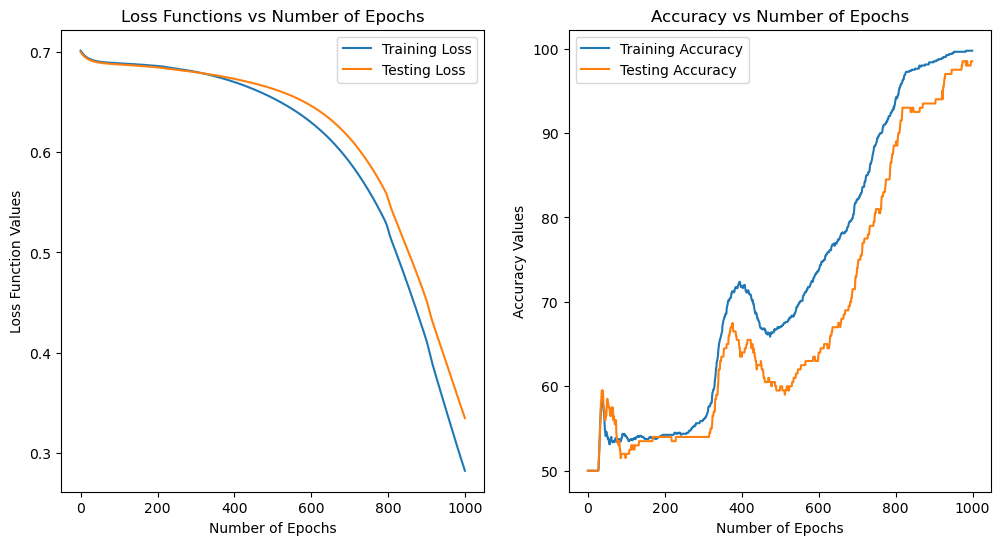

In [40]:
#now, lets plot the training / testing accuracy
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path 

PLOT_DIR = Path("plots")
PLOT_DIR.mkdir(parents=True,exist_ok=True)

PLOT_FILE = "model_3_exp1_plots"
PLOT_FILE_PATH = PLOT_DIR / PLOT_FILE

df = pd.read_csv(filepath_or_buffer=RESULTS_FILE_PATH) #now, this dataframe is just the csv in memory, and can be accessed the way csvs can be
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(df.epoch,df.train_loss,label="Training Loss")
plt.plot(df.epoch,df.test_loss,label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Values")
plt.title("Loss Functions vs Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(df.epoch,df.train_acc,label="Training Accuracy")
plt.plot(df.epoch,df.test_acc,label="Testing Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy Values")
plt.title("Accuracy vs Number of Epochs")
plt.legend()
##plt.show() the show command usually clears the current plot!

plt.savefig(PLOT_FILE_PATH)








In [41]:
#Now, lets to the same thing, only using the plot_descision_boundary in helper_functions.py (including the import, ie assume nothing)

from pathlib import Path 
import requests 

if Path("helper_functions.py").is_file():
    print(f"Already downloaded helper_functions.py. Skipping Download...")
else:
    print(f"Downloading helper_functions.py ...")
    request = requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    #now, the requests holds the data, but we want it written to our computer, so use a write command
    #requests object holds the data obtains from the https get request sent to github
    with open(file="helper_functions.py",mode="wb") as file:
        file.write(request.content)
        #file is a BufferedWriter, basically a file pointer in c, and you are writing to the file the binary contents in requests (a python file)


Already downloaded helper_functions.py. Skipping Download...


Text(0.5, 1.0, 'Testing Data')

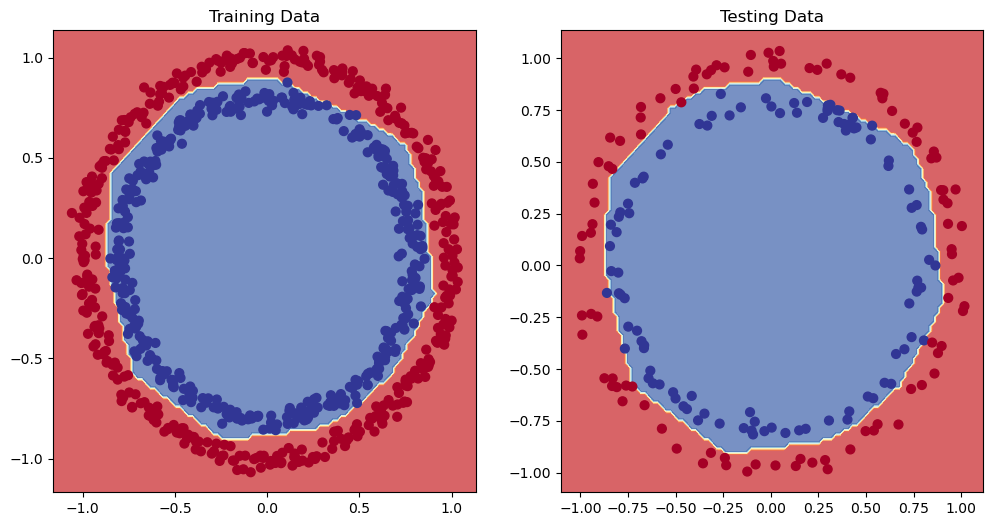

In [42]:
#now lets plot the descision boundary:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model=model_3,X=X_training,y=Y_training)
plt.title("Training Data")
plt.subplot(1,2,2)
plot_decision_boundary(model=model_3,X=X_testing,y=Y_testing)
plt.title("Testing Data")


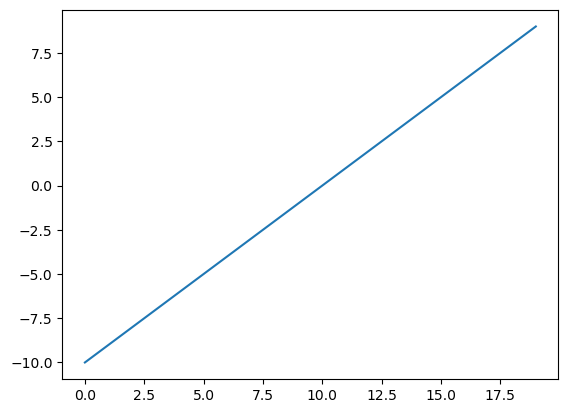

In [43]:
#NOW, LETS DIG A LITTLE DEEPER INTO WHAT THESE ACTIVATION FUNCTIONS ARE AND HOW THEY WORK:
#first, lets make some toy data:
A = torch.arange(start=-10,end=10,step=1)
plt.plot(A) #by default, it plots by having the second value be arange from 0 to the size of the other thing

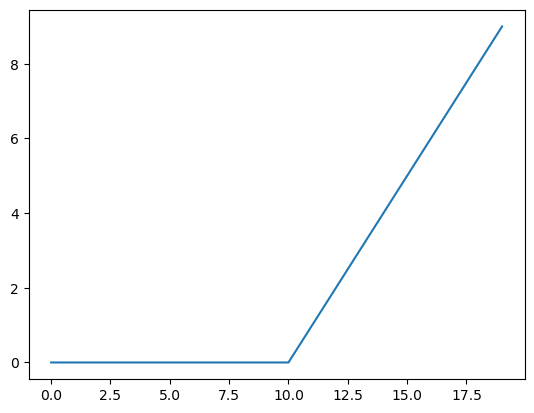

In [44]:
#lets see how ReLU affects it:

def relu (x):
    return torch.maximum(torch.tensor(0),x) #torch.max computes the element wise maximum, and since you put in tensor(0), it will be 
    #broadcastes to cover the entire other tensor.

plt.plot(relu(A))


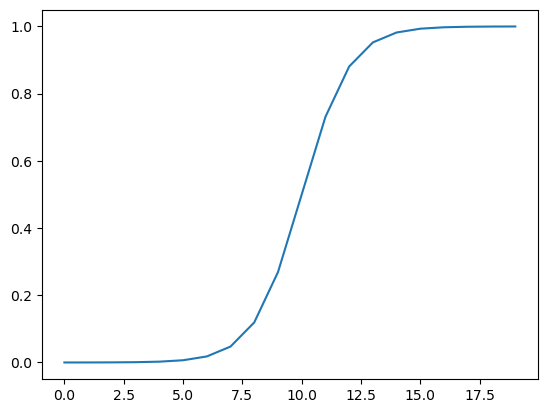

In [45]:
#now lets impliment the sigmoid function:

def sigmoid(x):
    return 1 / (1 + torch.exp(-x)) #returns a tensor with the exponentials of the tensor, ie, e to the element
plt.plot(sigmoid(A))